# SARIMA

SARIMA:
- The S accounts for the seasonality part of the model,
- The AR stands for autoregressive and refers to using lagged values of our target variable to make our prediction.
- The I stands for integrated. It means that instead of taking the raw target values, we are differencing them.
- The MA stands for moving average. A moving average model takes the lagged prediction errors as inputs.

## Data

The data comes from a pharmacy (shop) with daily and hourly sales of 8 different active ingredients of pharmaceutical drugs.

In [1]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller, kpss    ##### unit root test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm    ##### auto-arima
import warnings
warnings.filterwarnings("ignore")   ##### ignore warnings   

In [2]:
#import data
df_all = pd.read_csv('salesdaily.csv', usecols=[0,1,2,3,4,5,6,7,8])
#create 'ds' col
df_all["date"] = pd.to_datetime(df_all['datum'])
# use 'ds' as index
df_all.set_index(df_all['date'], inplace=True)
df_all.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,date
date,,,,,,,,,,
2014-01-02,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014-01-02
2014-01-03,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014-01-03
2014-01-04,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014-01-04
2014-01-05,1/5/2014,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014-01-05
2014-01-06,1/6/2014,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014-01-06


## R03 series (Sales daily data)

In [3]:
R03 = df_all[["R03"]]
R03.info()
R03.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-02 to 2019-10-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R03     2106 non-null   float64
dtypes: float64(1)
memory usage: 32.9 KB


,R03
date,
2014-01-02,0.0
2014-01-03,20.0
2014-01-04,9.0
2014-01-05,3.0
2014-01-06,6.0


The first observation is from 2014 and the last one from 2019.

<Figure size 432x288 with 0 Axes>

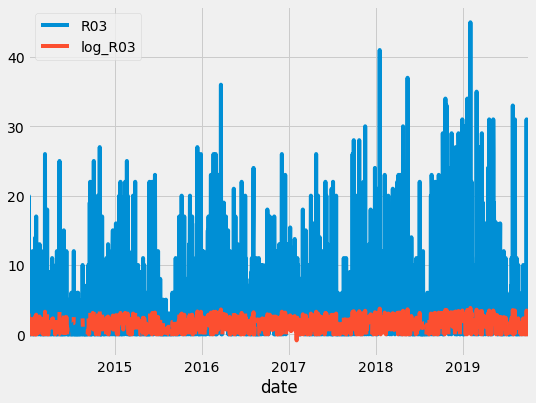

In [4]:
#make the log
R03['log_R03'] = np.log(R03['R03'])
# plot both time series
plt.figure() #nova figura
R03[['R03','log_R03']].plot(figsize=(8, 6)) #gráfico de linhas
plt.show()
# bad plot - time series with different scale

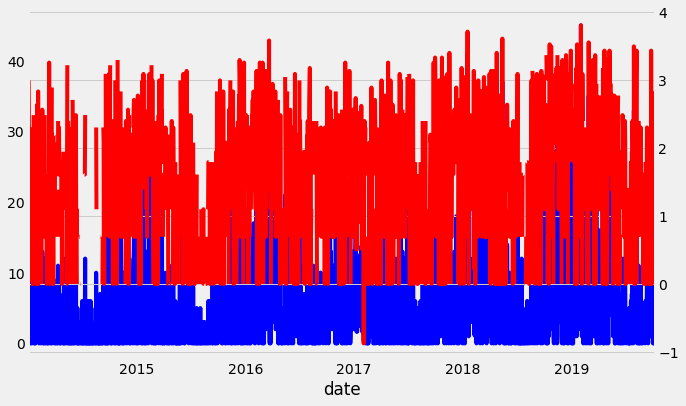

In [5]:
# better plot
# # make a plot with different y-axis using second axis object ('secondary_y')
plt.figure(figsize=(10,6))
R03.R03.plot(color="blue")
R03.log_R03.plot(secondary_y = True, color="red")
plt.show()

# observe the 2 y-axis with different scales

There is no need to use the log transformation.

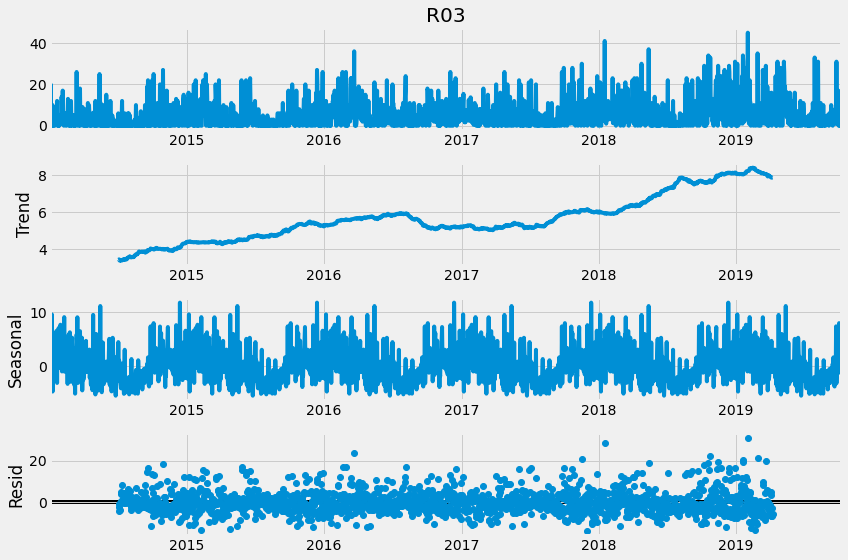

In [6]:
# components of time series
# from now we analyse the train set (R03_train)
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.rcParams.update({'font.size': 14})
# freq is the number of data points in a repeated cycle
result = seasonal_decompose(R03.R03, model='additive',period=365) #daily data

result.plot()
plt.show()
#1-plot- dados originais
#2-plot- tendência
#3-plot- sazonalidade
#4-plot- resíduos
#a série não parece ser estacionária, vamos confirmar com o teste de Adfuller

We observe seasonality.

In [7]:
test1_adf = adfuller(R03.R03, regression='c')
test1_kpss = kpss(R03.R03, regression='c')
print("ADF p-value = {}".format(test1_adf[1]))
if test1_adf[1] > 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
if test1_adf[1] <= 0.05:
    print("We reject the H0: stationary time series <-> we do not have a unit root")
print("KPSS p-value = {}".format(test1_kpss[1]))
if test1_kpss[1] > 0.05:
    print("We do not reject the H0: stationary time series <-> we do not have a unit root")
    
if test1_kpss[1] <= 0.05:
    print("We reject the H0: non-stationary time series <-> we have a unit root")

ADF p-value = 1.2305816766896379e-05
We reject the H0: stationary time series <-> we do not have a unit root
KPSS p-value = 0.01
We reject the H0: non-stationary time series <-> we have a unit root


The series is stationary ($p<.001$) basead on the augmented Dickey–Fuller test, while the Kwiatkowski–Phillips–Schmidt–Shin test suggests the opposite ($p = .01$). Since the results of both tests are incongruent a first difference of the logarithm will be produced.

[]

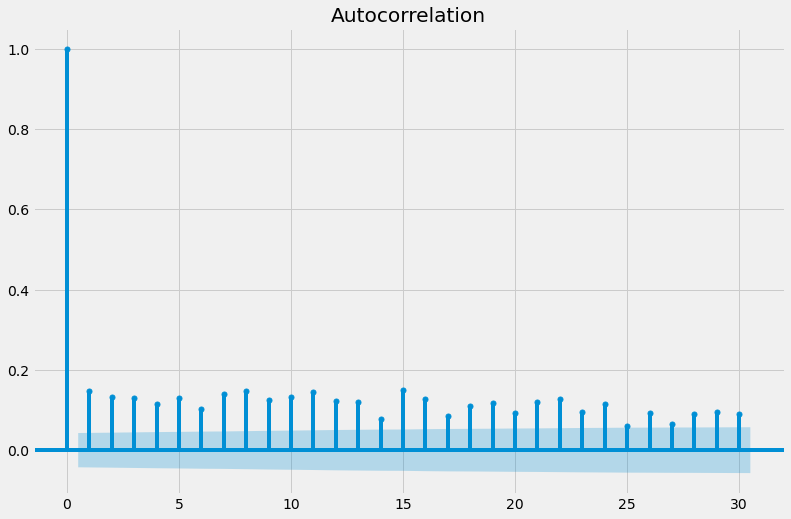

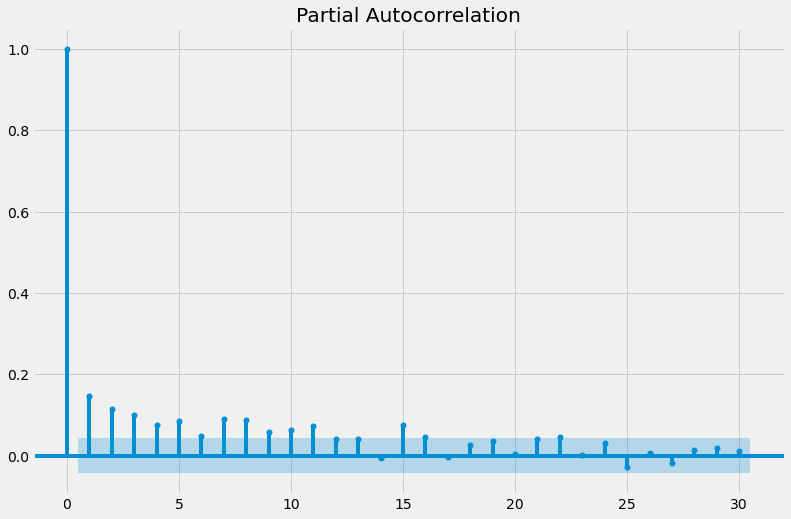

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# correlogram
plot_acf(R03.R03, lags=30, alpha=0.05)
plot_pacf(R03.R03, lags=30, alpha=0.05)
plt.plot()

In [9]:
#create a first lag
R03_series=R03[["R03"]]
dflg_R03 = np.log(R03_series + 1).diff().dropna()
print(dflg_R03.shape)

(2105, 1)


One observation was removed.

In [10]:
dflg_R03.head(3)

,R03
date,
2014-01-03,3.044522
2014-01-04,-0.741937
2014-01-05,-0.916291


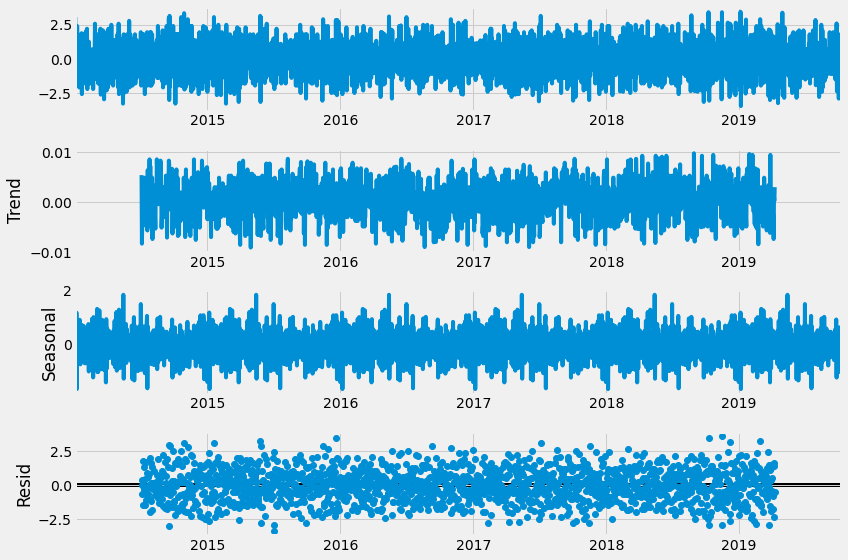

In [11]:
result = seasonal_decompose(dflg_R03, model='additive',period=365)

result.plot()
plt.show()

In [12]:
dflg_R03.head()

,R03
date,
2014-01-03,3.044522
2014-01-04,-0.741937
2014-01-05,-0.916291
2014-01-06,0.559616
2014-01-07,-1.945910


Text(0.5, 1.0, 'Box Plot - Diff Log R03')

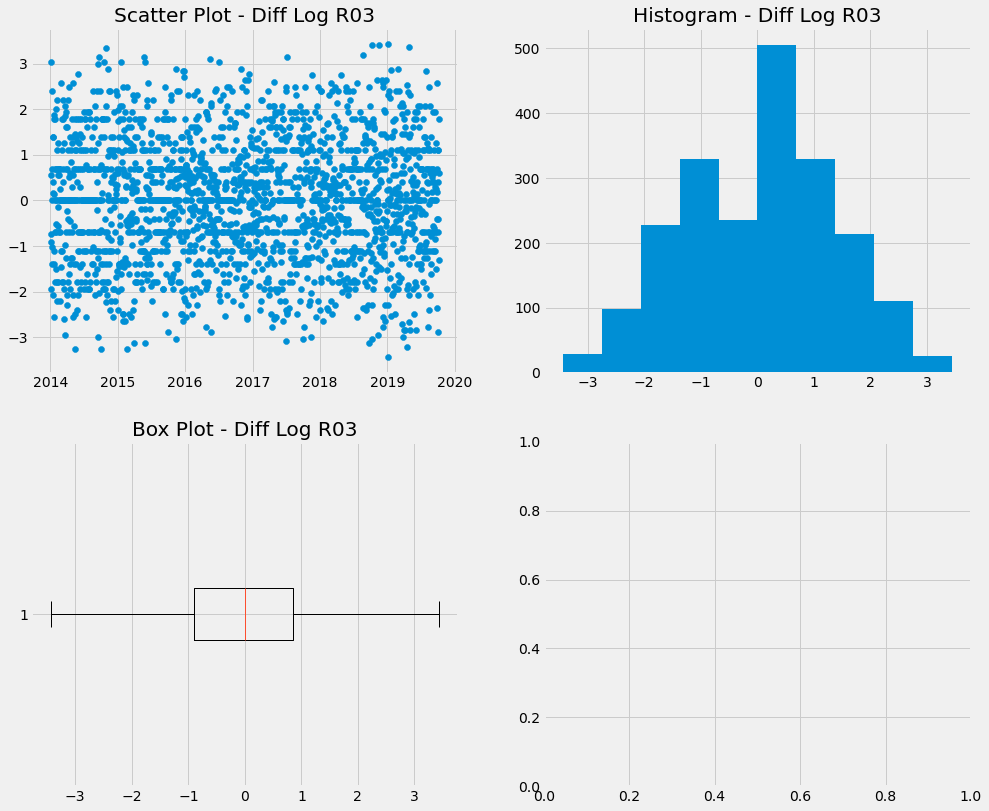

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(15, 13))
ax[0,0].scatter(y=dflg_R03, x=dflg_R03.index)
ax[0,0].set_title('Scatter Plot - Diff Log R03')
ax[0,1].hist(dflg_R03['R03'])
ax[0,1].set_title('Histogram - Diff Log R03')
ax[1,0].boxplot(dflg_R03['R03'], vert=False)
ax[1,0].set_title('Box Plot - Diff Log R03')

In [14]:
test1_adf = adfuller(dflg_R03, regression='c')
test1_kpss = kpss(dflg_R03, regression='c')
print("ADF p-value = {}".format(test1_adf[1]))
if test1_adf[1] > 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
if test1_adf[1] <= 0.05:
    print("We reject the H0: stationary time series <-> we do not have a unit root")
print("KPSS p-value = {}".format(test1_kpss[1]))
if test1_kpss[1] > 0.05:
    print("We do not reject the H0: stationary time series <-> we do not have a unit root")
    
if test1_kpss[1] <= 0.05:
    print("We reject the H0: non-stationary time series <-> we have a unit root")

ADF p-value = 4.574017482587059e-29
We reject the H0: stationary time series <-> we do not have a unit root
KPSS p-value = 0.1
We do not reject the H0: stationary time series <-> we do not have a unit root


The series is stationary ($p<.001$) basead on the augmented Dickey–Fuller test, and based on the Kwiatkowski–Phillips–Schmidt–Shin test ($p = .10$).

[]

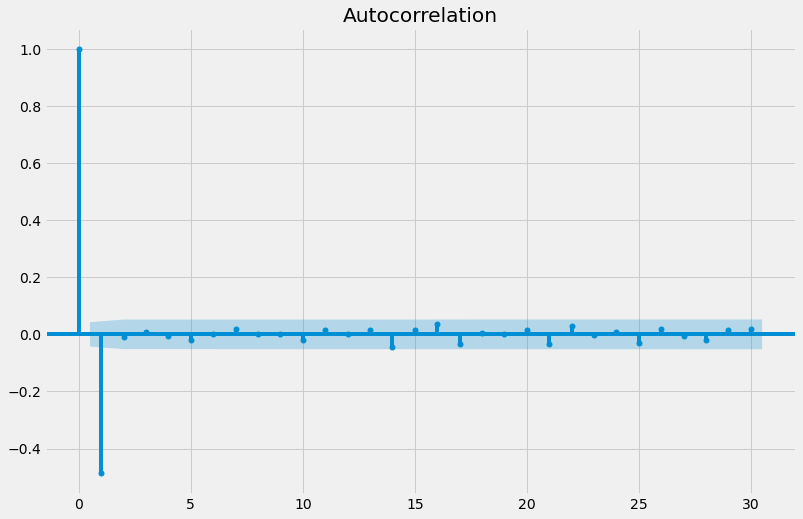

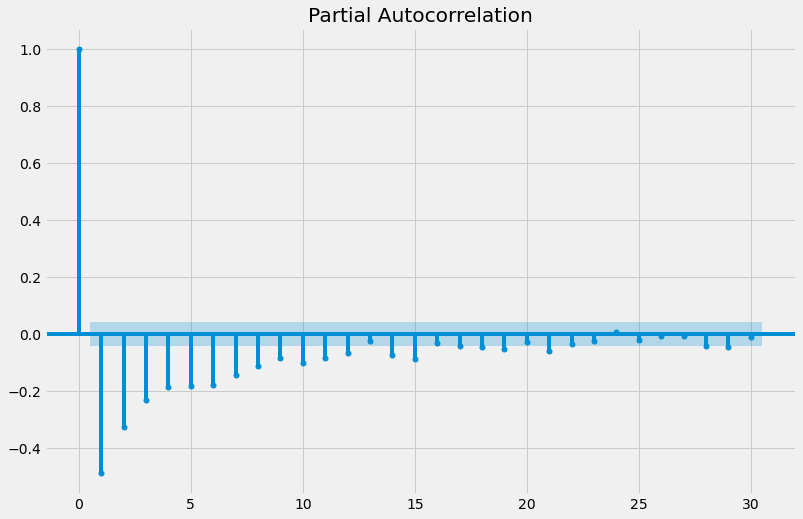

In [15]:
# correlogram
plot_acf(dflg_R03, lags=30, alpha=0.05)
plot_pacf(dflg_R03, lags=30, alpha=0.05)
plt.plot()

The series of the active ingredient R03 is stationary at level. It comes stationary in the first difference of the Napierian logarithm.

In [16]:
import statsmodels.api as sm

mod = sm.tsa.arima.ARIMA(dflg_R03, order=(0, 1, 1), seasonal_order=(0, 1, 1, 365))
res = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')

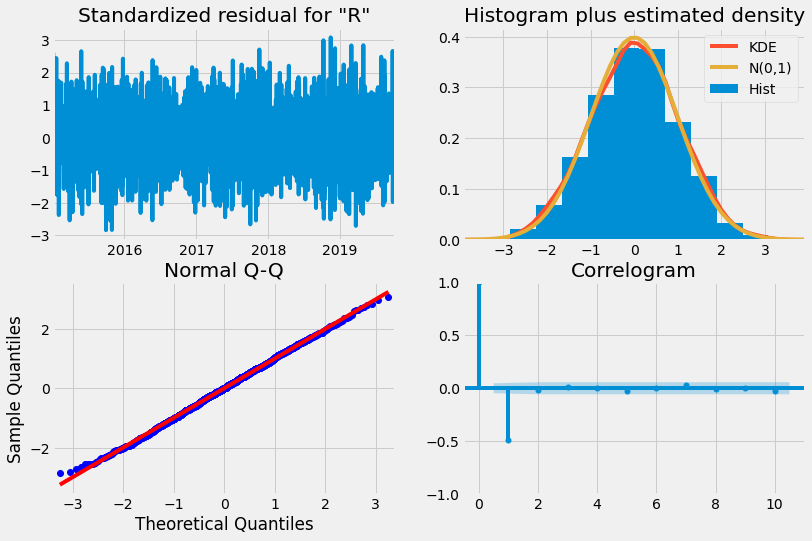

In [17]:
res.plot_diagnostics()
plt.show()

In [18]:
#if train test split is needed
split_index = int(len(R03)*0.8)
R03_train = R03.iloc[:split_index,:]
R03_test = R03.iloc[split_index:,:]
print('Train: {} | Test: {}'.format(R03_train.shape, R03_test.shape))

Train: (1684, 2) | Test: (422, 2)


In [19]:
R03_train.head()

,R03,log_R03
date,,
2014-01-02,0.0,-inf
2014-01-03,20.0,2.995732
2014-01-04,9.0,2.197225
2014-01-05,3.0,1.098612
2014-01-06,6.0,1.791759


In [20]:
R03_test.head()

,R03,log_R03
date,,
2018-08-13,3.0,1.098612
2018-08-14,4.0,1.386294
2018-08-15,0.0,-inf
2018-08-16,5.0,1.609438
2018-08-17,5.0,1.609438


In [21]:
R03_train_vec=R03_train['R03']
stepwise_fit = pm.auto_arima(R03_train_vec, start_p=1,
                             start_q=1,max_p=4, max_q=4, 
                             m=30, #the model cannot handle with 365
                             start_P=0,
                             seasonal=True,
                             d=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=10581.356, Time=16.29 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=10687.181, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=10650.813, Time=3.55 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=10653.677, Time=3.73 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=11612.194, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=10580.073, Time=1.45 sec
 ARIMA(1,0,1)(1,0,0)[30] intercept   : AIC=10581.413, Time=15.35 sec
 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=18.84 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=10660.303, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=10656.407, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=10579.572, Time=2.57 sec
 ARIMA(2,0,1)(1,0,0)[30] intercept   : AIC=10580.946, Time=19.01 sec
 ARIMA(2,0,1)(0,0,1)[30] intercept   : AIC=10580.842, Time=18.22 sec
 ARIMA(2,0,1)(1,0,1)[30] intercept   : AIC=10643.787, Time=20.31 sec
 ARIM

In [22]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1684
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -5284.731
Date:                Sun, 20 Jun 2021   AIC                          10579.462
Time:                        11:13:06   BIC                          10606.607
Sample:                             0   HQIC                         10589.516
                               - 1684                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0709      0.037      1.903      0.057      -0.002       0.144
ar.L1          0.9854      0.007    139.992      0.000       0.972       0.999
ma.L1         -0.9011      0.024    -37.232      0.000      -0.948      -0.854
ma.L2         -0.0402      0.025     -1.608      0.108      -0.089       0.009
sigma2        31.1297      0.874     35.600      0.000      29.416      32.844
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1961.56
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

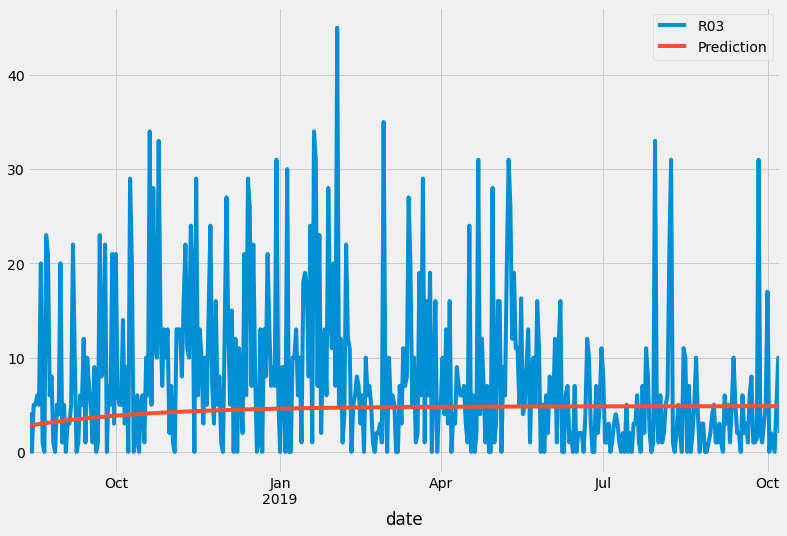

In [23]:
R03_test_vec=R03_test['R03']
future_forecast = stepwise_fit.predict(n_periods=len(R03_test_vec))

# join the forecasted value and the R03_test values in the same dataframe and plot both
future_forecast = pd.DataFrame(future_forecast,index = R03_test_vec.index,columns=['Prediction'])
pd.concat([R03_test_vec,future_forecast],axis=1).plot()
plt.show()

<AxesSubplot:xlabel='date'>

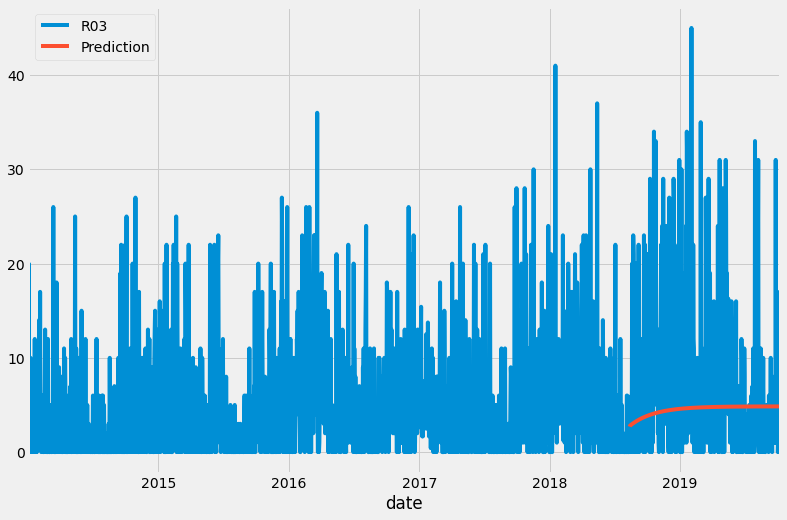

In [24]:
# plot original R03 time series and the forecast (last 422 values)
pd.concat([R03['R03'],future_forecast],axis=1).plot()

In [25]:
# forecast performance metrics
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model=stepwise_fit
forecasts, conf_int = model.predict(n_periods=422, return_conf_int=True)
    
print(f"Mean squared error: {mean_squared_error(R03_test_vec, forecasts)}")
print(f"SMAPE: {smape(R03_test_vec, forecasts)}")

Mean squared error: 78.142789055774
SMAPE: 94.72305343391895


In [26]:
test_vec=np.asarray(R03_test["R03"])

vec_no_inf=(test_vec-forecasts)/test_vec
from numpy import inf
vec_no_inf[vec_no_inf == -inf] = 0

# Mean Absolute Percentage Error
MAPE = np.mean(np.abs(vec_no_inf) * 100)

print('The Mean Absolute Percentage Error for the forecast of the last 422 values is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of the last 422 values is 79.52%


In [27]:
# Let's fit this model
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(R03_train_vec,order=(0,1,1),seasonal_order=(0,1,1,30), #modelo definido com base nas análises anteriores
              enforce_stationarity=False, enforce_invertibility=False)

results = mod.fit()
results.summary() #neste caso o sarimax é melhor do que o automodelo sarima (com base no AIC)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                R03   No. Observations:                 1684
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 30)   Log Likelihood               -5150.813
Date:                            Sun, 20 Jun 2021   AIC                          10307.625
Time:                                    11:13:26   BIC                          10323.797
Sample:                                01-02-2014   HQIC                         10313.626
                                     - 08-12-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9510      0.008   -126.611      0.000      -0.966      -0.936
ma.S.L30      -1.0000     42.439     -0.024      0.981     -84.178      82.178
sigma2        31.6690   1344.285      0.024      0.981   -2603.081    2666.420
===================================================================================
Ljung-Box (L1) (Q):                   3.32   Jarque-Bera (JB):              1513.86
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             1.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

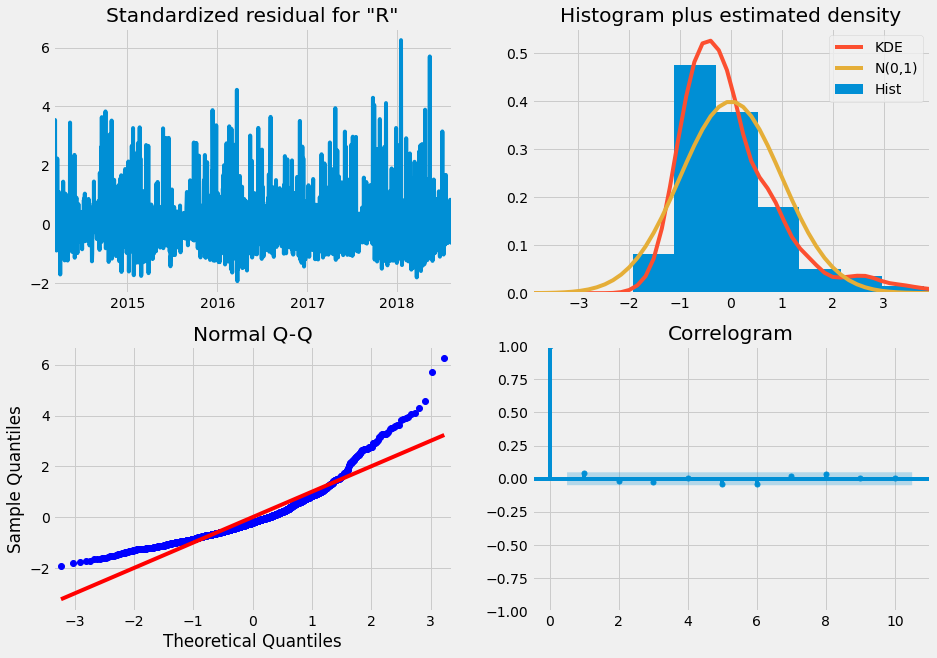

In [28]:
results.plot_diagnostics(figsize=(14, 10))
plt.show()

In [29]:
# train and test set
train_data = R03['2014-01-02':'2018-08-12']
test_data = R03['2018-08-13':'2019-10-08']


In [30]:
# static prediction
pred0 = results.get_prediction(start='2014-01-02', dynamic=False) #predição estática desde o começo, primeira data
pred0_ci = pred0.conf_int()
# dynamic prediction
pred1 = results.get_prediction(start='2014-01-02', dynamic=True) #previção dinâmica
pred1_ci = pred1.conf_int()

In [31]:
# out-of-sample prediction (forecast) based on sarimax model
pred2 = results.get_forecast('2019-10-08') #previsão fora da amostra
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2018-08-13':'2019-10-08'])

2018-08-13    1.452499
2018-08-14    2.349076
2018-08-15    0.982262
2018-08-16    2.309641
2018-08-17    1.407856
                ...   
2019-10-04    1.471250
2019-10-05    1.367450
2019-10-06    0.782655
2019-10-07    0.790594
2019-10-08    1.687170
Freq: D, Name: predicted_mean, Length: 422, dtype: float64


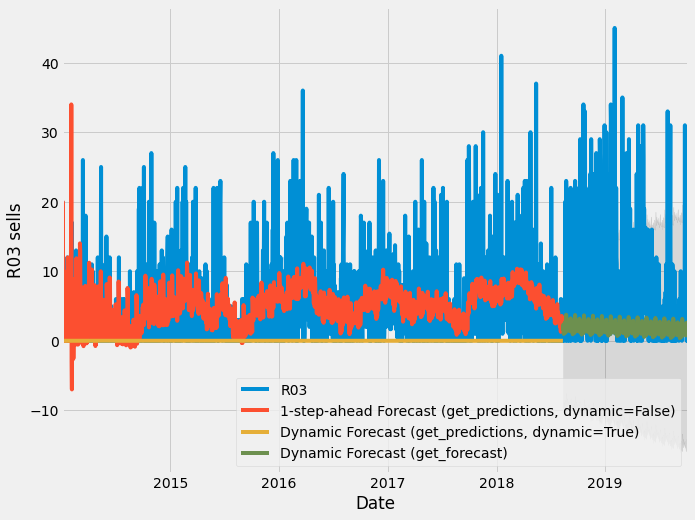

In [32]:
# plot all predictions
ax = R03["R03"].plot(figsize=(10, 8))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('R03 sells')
plt.xlabel('Date')
plt.legend()
plt.show()

In [33]:
prediction = pred2.predicted_mean['2018-08-13':'2019-10-08'].values

vec_no_inf=(test_vec-prediction)/test_vec
from numpy import inf
vec_no_inf[vec_no_inf == -inf] = 0

# Mean Absolute Percentage Error
MAPE = np.mean(np.abs(vec_no_inf) * 100)

print('The Mean Absolute Percentage Error for the R03 sells from year 2018 to 2019 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the GDP forecast from year 2018 to 2019 is 61.29%


## R06 series (Sales daily data)

In [34]:
R06 = df_all[["R06"]]
R06.info()
R06.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-02 to 2019-10-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R06     2106 non-null   float64
dtypes: float64(1)
memory usage: 112.9 KB


,R06
date,
2014-01-02,2.0
2014-01-03,4.0
2014-01-04,1.0
2014-01-05,0.0
2014-01-06,2.0


The first observation is from 2014 and the last one from 2019.

<Figure size 864x576 with 0 Axes>

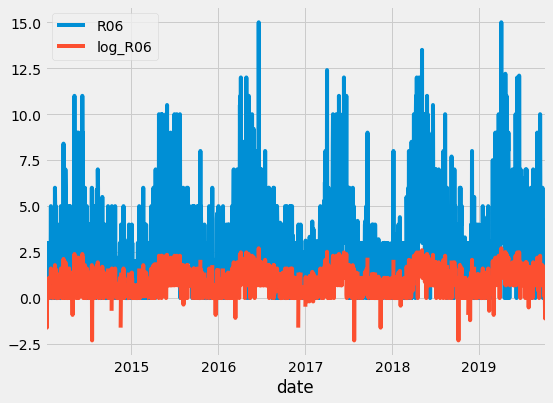

In [35]:
#make the log
R06['log_R06'] = np.log(R06['R06'])
# plot both time series
plt.figure() #new plot
R06[['R06','log_R06']].plot(figsize=(8, 6))
plt.show()
# bad plot - time series with different scale

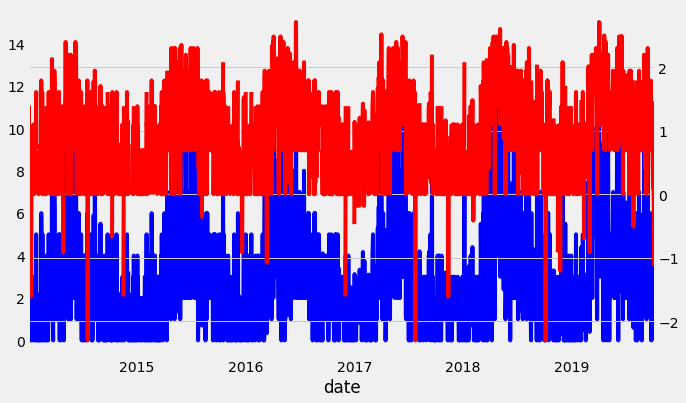

In [36]:
# better plot
# # make a plot with different y-axis using second axis object ('secondary_y')
plt.figure(figsize=(10,6))
R06.R06.plot(color="blue")
R06.log_R06.plot(secondary_y = True, color="red")
plt.show()

# observe the 2 y-axis with different scales

There is no need to use the log transformation.

In [37]:
#if train test split is needed
#split_index = int(len(R06)*0.8)
#R06_train = R06.iloc[:split_index,:]
#R06_test = R06.iloc[split_index:,:]
#print('Train: {} | Test: {}'.format(R06_train.shape, R06_test.shape))

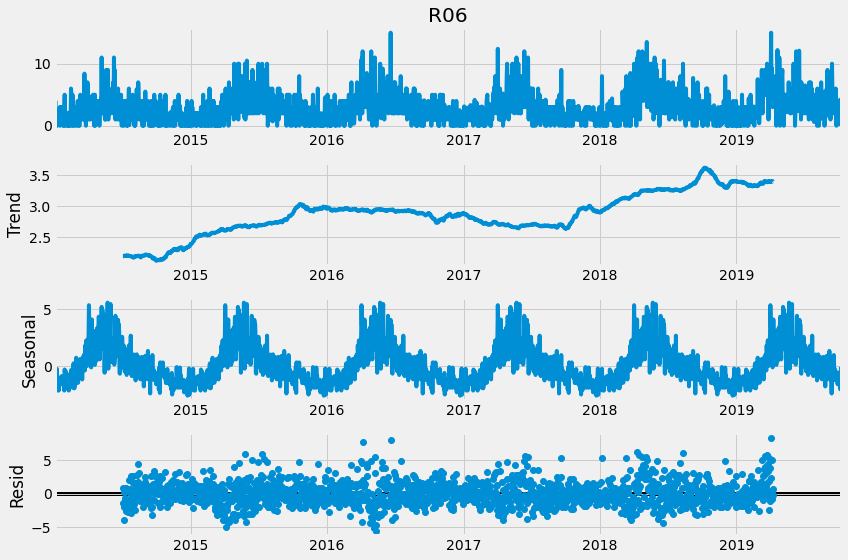

In [38]:
result = seasonal_decompose(R06.R06, model='additive',period=365)

result.plot()
plt.show()
#1-plot- dados originais
#2-plot- tendência
#3-plot- sazonalidade
#4-plot- resíduos
#a série não parece ser estacionária, vamos confirmar com o teste de Adfuller

We observe seasonality.

In [39]:
test1_adf = adfuller(R06.R06, regression='c')
test1_kpss = kpss(R06.R06, regression='c')
print("ADF p-value = {}".format(test1_adf[1]))
if test1_adf[1] > 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
if test1_adf[1] <= 0.05:
    print("We reject the H0: stationary time series <-> we do not have a unit root")
print("KPSS p-value = {}".format(test1_kpss[1]))
if test1_kpss[1] > 0.05:
    print("We do not reject the H0: stationary time series <-> we do not have a unit root")
    
if test1_kpss[1] <= 0.05:
    print("We reject the H0: non-stationary time series <-> we have a unit root")

ADF p-value = 0.002409743152740142
We reject the H0: stationary time series <-> we do not have a unit root
KPSS p-value = 0.023294265273671268
We reject the H0: non-stationary time series <-> we have a unit root


The series is stationary ($p=.002$) basead on the augmented Dickey–Fuller test, while the Kwiatkowski–Phillips–Schmidt–Shin test suggests the opposite ($p = .023$) base on the type I erro of $5\%$ ($\alpha = .05$). Since the results of both tests are incongruent a first difference of the logarithm will be produced.

[]

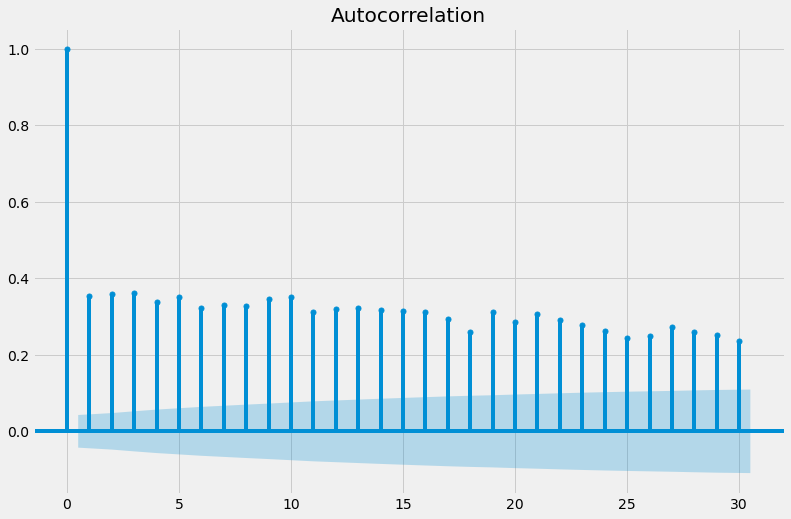

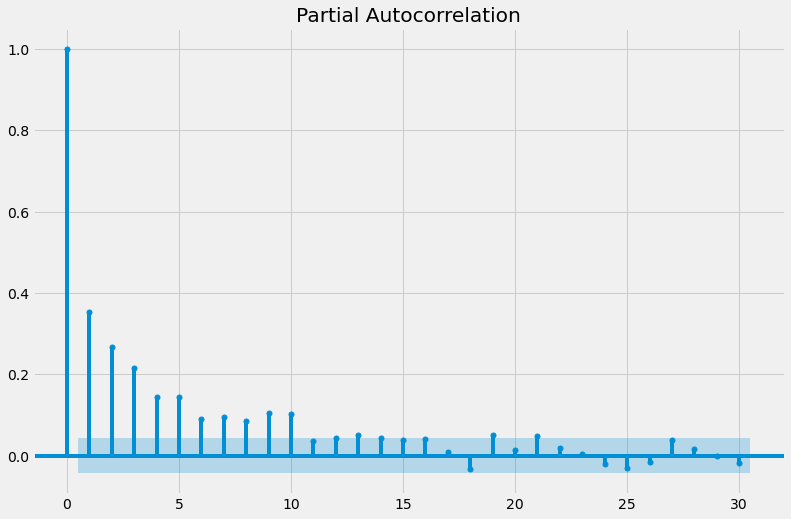

In [40]:
# correlogram
plot_acf(R06.R06, lags=30, alpha=0.05)
plot_pacf(R06.R06, lags=30, alpha=0.05)
plt.plot()

In [41]:
#create a first lag
R06_series=R06[["R06"]]
dflg_R06 = np.log(R06_series + 1).diff().dropna()
print(dflg_R06.shape)

(2105, 1)


One observation was removed.

In [42]:
dflg_R06.head(3)

,R06
date,
2014-01-03,0.510826
2014-01-04,-0.916291
2014-01-05,-0.693147


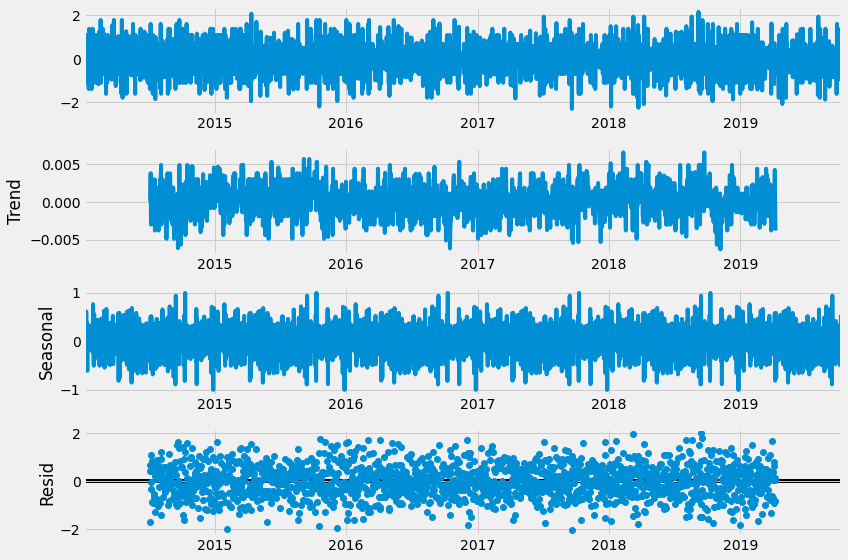

In [43]:
result = seasonal_decompose(dflg_R06, model='additive',period=365)

result.plot()
plt.show()

In [44]:
dflg_R06.head()

,R06
date,
2014-01-03,0.510826
2014-01-04,-0.916291
2014-01-05,-0.693147
2014-01-06,1.098612
2014-01-07,-1.098612


Text(0.5, 1.0, 'Box Plot - Diff Log R06')

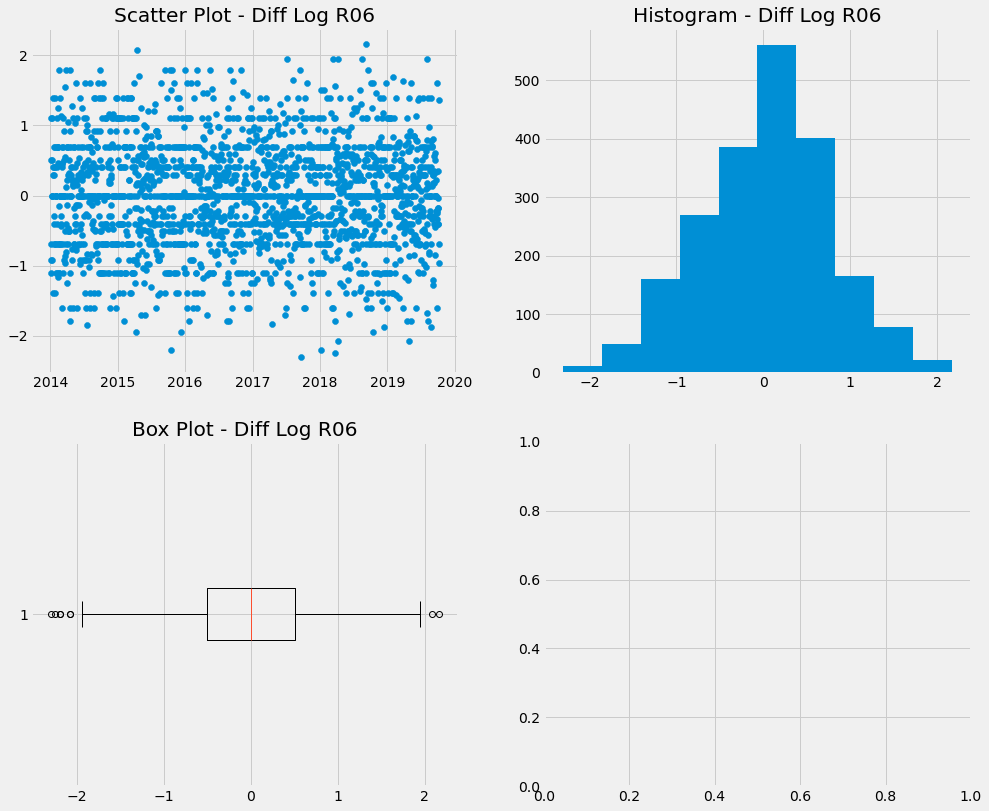

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(15, 13))
ax[0,0].scatter(y=dflg_R06, x=dflg_R06.index)
ax[0,0].set_title('Scatter Plot - Diff Log R06')
ax[0,1].hist(dflg_R06['R06'])
ax[0,1].set_title('Histogram - Diff Log R06')
ax[1,0].boxplot(dflg_R06['R06'], vert=False)
ax[1,0].set_title('Box Plot - Diff Log R06')

In [46]:
test1_adf = adfuller(dflg_R06, regression='c')
test1_kpss = kpss(dflg_R06, regression='c')
print("ADF p-value = {}".format(test1_adf[1]))
if test1_adf[1] > 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")
if test1_adf[1] <= 0.05:
    print("We reject the H0: stationary time series <-> we do not have a unit root")
print("KPSS p-value = {}".format(test1_kpss[1]))
if test1_kpss[1] > 0.05:
    print("We do not reject the H0: stationary time series <-> we do not have a unit root")
    
if test1_kpss[1] <= 0.05:
    print("We reject the H0: non-stationary time series <-> we have a unit root")

ADF p-value = 4.300495721323831e-29
We reject the H0: stationary time series <-> we do not have a unit root
KPSS p-value = 0.1
We do not reject the H0: stationary time series <-> we do not have a unit root


The series is stationary ($p<.001$) basead on the augmented Dickey–Fuller test, and based on the Kwiatkowski–Phillips–Schmidt–Shin test ($p = .10$) using $\alpha = .05$.

[]

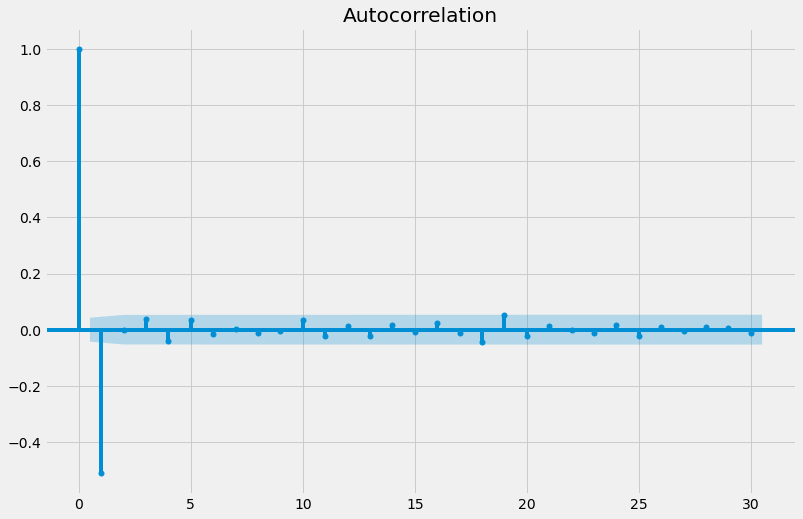

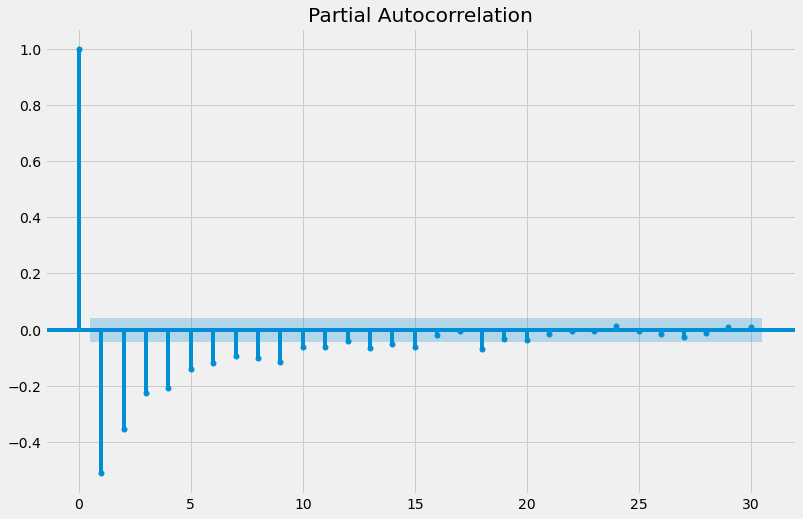

In [47]:
# correlogram
plot_acf(dflg_R06, lags=30, alpha=0.05)
plot_pacf(dflg_R06, lags=30, alpha=0.05)
plt.plot()

The series of the active ingredient R06 is stationary at level. It comes stationary in the first difference of the Napierian logarithm.

In [48]:
import statsmodels.api as sm

mod = sm.tsa.arima.ARIMA(dflg_R06, order=(0, 1, 1), seasonal_order=(0, 1, 1, 365))
res = mod.fit(method='innovations_mle', low_memory=True, cov_type='none')

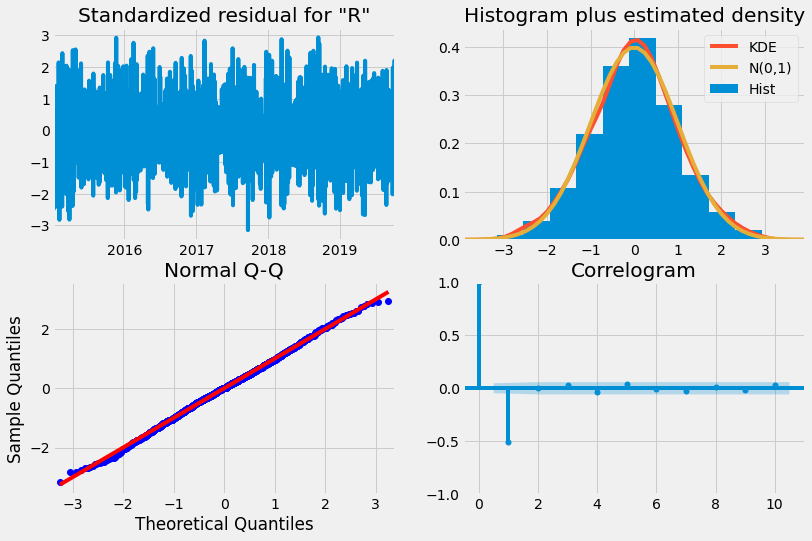

In [49]:
res.plot_diagnostics()
plt.show()

In [50]:
#if train test split is needed
split_index = int(len(R06)*0.8)
R06_train = R06.iloc[:split_index,:]
R06_test = R06.iloc[split_index:,:]
print('Train: {} | Test: {}'.format(R06_train.shape, R06_test.shape))

Train: (1684, 2) | Test: (422, 2)


In [51]:
R06_train.head()

,R06,log_R06
date,,
2014-01-02,2.0,0.693147
2014-01-03,4.0,1.386294
2014-01-04,1.0,0.000000
2014-01-05,0.0,-inf
2014-01-06,2.0,0.693147


In [52]:
R06_test.head()

,R06,log_R06
date,,
2018-08-13,2.0,0.693147
2018-08-14,5.0,1.609438
2018-08-15,1.0,0.000000
2018-08-16,5.0,1.609438
2018-08-17,1.0,0.000000


In [53]:
R06_train_vec=R06_train['R06']
stepwise_fit = pm.auto_arima(R06_train_vec, start_p=1,
                             start_q=1,max_p=4, max_q=4, 
                             m=30, #the model cannot handle with 365
                             start_P=0,
                             seasonal=True,
                             d=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=7120.286, Time=10.49 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=7698.279, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=7467.738, Time=3.49 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=7524.234, Time=2.99 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=9160.145, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=7119.650, Time=1.02 sec
 ARIMA(1,0,1)(1,0,0)[30] intercept   : AIC=7120.313, Time=10.69 sec
 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=18.56 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=7556.482, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=7480.508, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=7121.236, Time=1.21 sec
 ARIMA(1,0,2)(0,0,0)[30] intercept   : AIC=7121.238, Time=1.29 sec
 ARIMA(0,0,2)(0,0,0)[30] intercept   : AIC=7471.100, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=7357.013, Time=0.30 sec
 ARIMA(2,0,2)(0,0,0)[

In [54]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1684
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -3555.825
Date:                Sun, 20 Jun 2021   AIC                           7119.650
Time:                        11:18:09   BIC                           7141.365
Sample:                             0   HQIC                          7127.693
                               - 1684                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0330      0.015      2.222      0.026       0.004       0.062
ar.L1          0.9881      0.004    239.051      0.000       0.980       0.996
ma.L1         -0.8902      0.011    -81.173      0.000      -0.912      -0.869
sigma2         3.9930      0.114     35.046      0.000       3.770       4.216
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               507.80
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.98
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

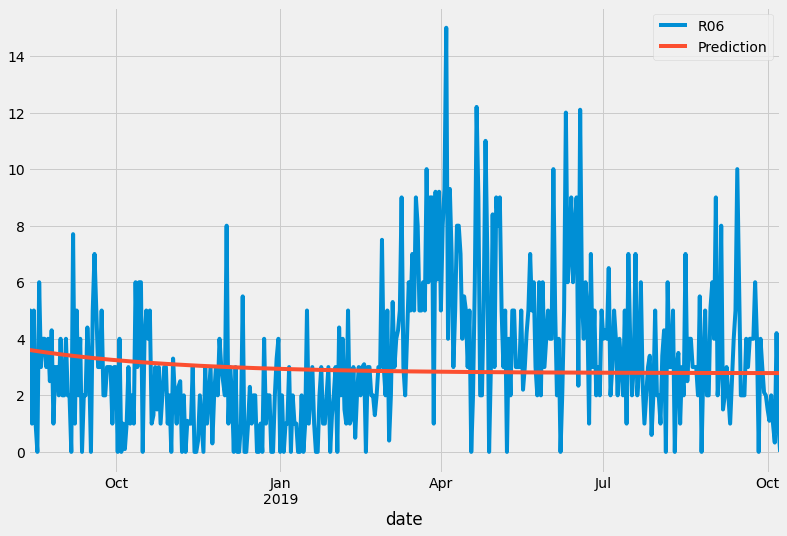

In [55]:
R06_test_vec=R06_test['R06']
future_forecast = stepwise_fit.predict(n_periods=len(R06_test_vec))

# join the forecasted value and the R06_test values in the same dataframe and plot both
future_forecast = pd.DataFrame(future_forecast,index = R06_test_vec.index,columns=['Prediction'])
pd.concat([R06_test_vec,future_forecast],axis=1).plot()
plt.show()

<AxesSubplot:xlabel='date'>

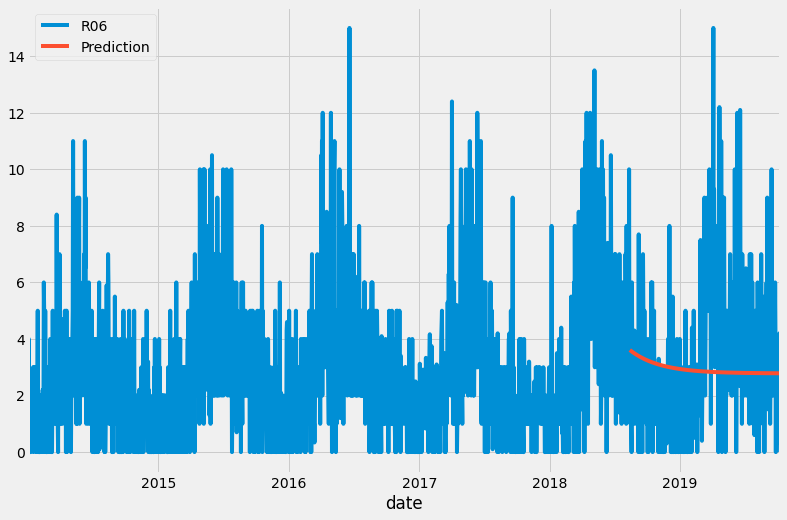

In [56]:
# plot original R06 time series and the forecast (last 422 values)
pd.concat([R06['R06'],future_forecast],axis=1).plot()

In [57]:
model=stepwise_fit
forecasts, conf_int = model.predict(n_periods=422, return_conf_int=True)
    
print(f"Mean squared error: {mean_squared_error(R06_test_vec, forecasts)}")
print(f"SMAPE: {smape(R06_test_vec, forecasts)}")

Mean squared error: 6.748979183093677
SMAPE: 66.76942739942024


In [58]:
test_vec=np.asarray(R06_test["R06"])

vec_no_inf=(test_vec-forecasts)/test_vec
from numpy import inf
vec_no_inf[vec_no_inf == -inf] = 0

# Mean Absolute Percentage Error
MAPE = np.mean(np.abs(vec_no_inf) * 100)

print('The Mean Absolute Percentage Error for the forecast of the last 422 values is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of the last 422 values is 67.17%


In [59]:
mod = SARIMAX(R06_train_vec,order=(0,1,1),seasonal_order=(0,1,1,30), #modelo definido com base nas análises anteriores
              enforce_stationarity=False, enforce_invertibility=False)

results = mod.fit()
results.summary() #neste caso o sarimax é melhor do que o automodelo sarima (com base no AIC)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                R06   No. Observations:                 1684
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 30)   Log Likelihood               -3488.387
Date:                            Sun, 20 Jun 2021   AIC                           6982.775
Time:                                    11:18:25   BIC                           6998.947
Sample:                                01-02-2014   HQIC                          6988.776
                                     - 08-12-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8983      0.009   -101.899      0.000      -0.916      -0.881
ma.S.L30      -1.0037      0.109     -9.172      0.000      -1.218      -0.789
sigma2         4.0582      0.504      8.050      0.000       3.070       5.046
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               316.75
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.78
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

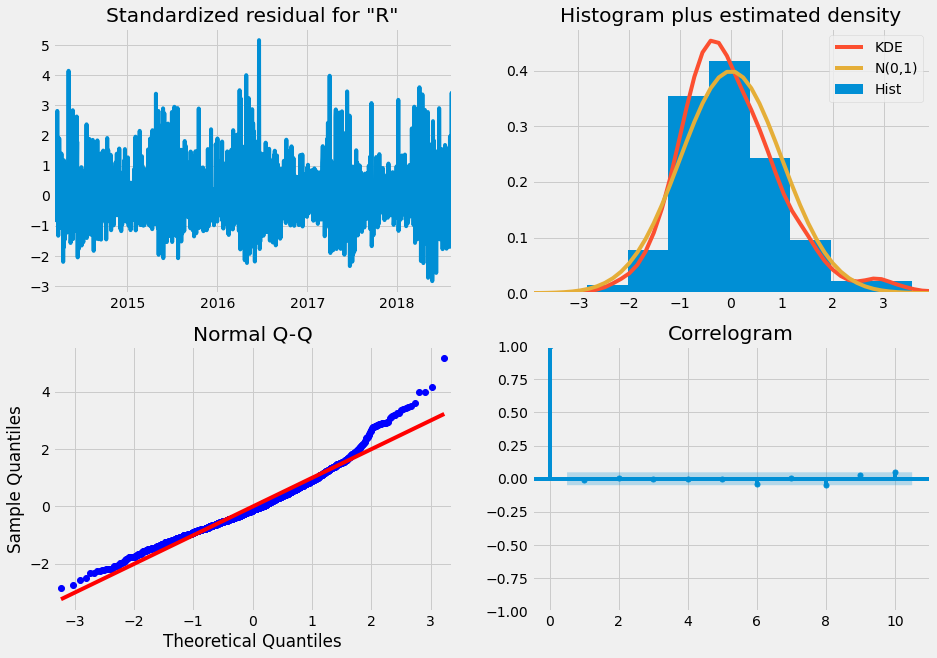

In [60]:
results.plot_diagnostics(figsize=(14, 10))
plt.show()

In [61]:
# train and test set
train_data = R06['2014-01-02':'2018-08-12']
test_data = R06['2018-08-13':'2019-10-08']


In [62]:
# static prediction
pred0 = results.get_prediction(start='2014-01-02', dynamic=False) #predição estática desde o começo, primeira data
pred0_ci = pred0.conf_int()
# dynamic prediction
pred1 = results.get_prediction(start='2014-01-02', dynamic=True) #previção dinâmica
pred1_ci = pred1.conf_int()

In [63]:
# out-of-sample prediction (forecast) based on sarimax model
pred2 = results.get_forecast('2019-10-08') #previsão fora da amostra
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2018-08-13':'2019-10-08'])

2018-08-13    3.701165
2018-08-14    3.809541
2018-08-15    3.814146
2018-08-16    3.546359
2018-08-17    3.707527
                ...   
2019-10-04    4.298737
2019-10-05    4.235946
2019-10-06    4.220730
2019-10-07    4.266711
2019-10-08    4.375087
Freq: D, Name: predicted_mean, Length: 422, dtype: float64


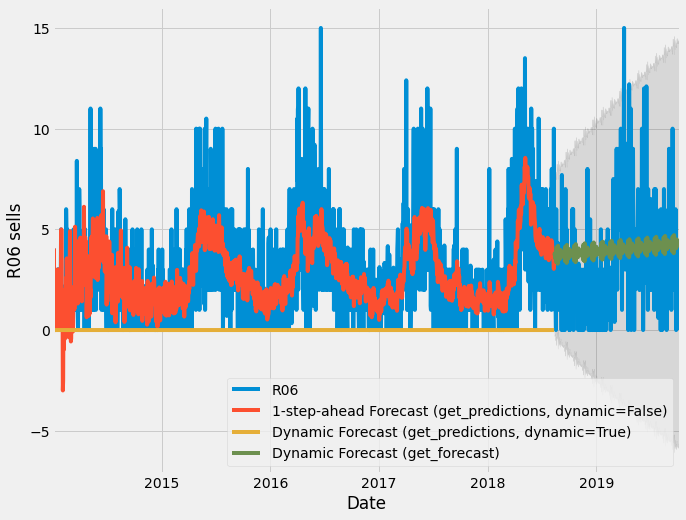

In [64]:
# plot all predictions
ax = R06["R06"].plot(figsize=(10, 8))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('R06 sells')
plt.xlabel('Date')
plt.legend()
plt.show()

In [65]:
prediction = pred2.predicted_mean['2018-08-13':'2019-10-08'].values

vec_no_inf=(test_vec-prediction)/test_vec
from numpy import inf
vec_no_inf[vec_no_inf == -inf] = 0

# Mean Absolute Percentage Error
MAPE = np.mean(np.abs(vec_no_inf) * 100)

print('The Mean Absolute Percentage Error for the R06 selss from year 2018 to 2019 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the GDP forecast from year 2018 to 2019 is 92.23%
